# Face Recognition - Data Preparation and PCA
This notebook covers loading the ORL face dataset, preparing the data matrix and label vector, and performing PCA using scikit-learn.

In [1]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Constants
IMAGE_WIDTH = 92
IMAGE_HEIGHT = 112
DATASET_PATH = './data/'  # Change this to your actual dataset path

def load_images_and_labels(dataset_path):
    data = []
    labels = []
    for subject_id in range(1, 41):
        subject_path = os.path.join(dataset_path, f's{subject_id}')
        for img_name in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_id)
    return np.array(data), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(DATASET_PATH)
print(f'Data shape: {X.shape}, Labels shape: {y.shape}')

Data shape: (400, 10304), Labels shape: (400,)


In [23]:
# Split into training and testing
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (200, 10304), Test shape: (200, 10304)


## PCA

Steps in PCA 
- Center the data: X = X - μ 
- Compute covariance matrix 
- Extract eigenvectors and eigenvalues 
- Project to new basis: Z = XW
- Reconstruct data: X = ZW^T + μ

In [3]:
from pca import PCA_GHALBAN
# from sklearn.metrics import pairwise_distances

pca = PCA_GHALBAN(alpha=0.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train) 

# print(f'PCA with GHALBAN, Components retained: {pca.components}')

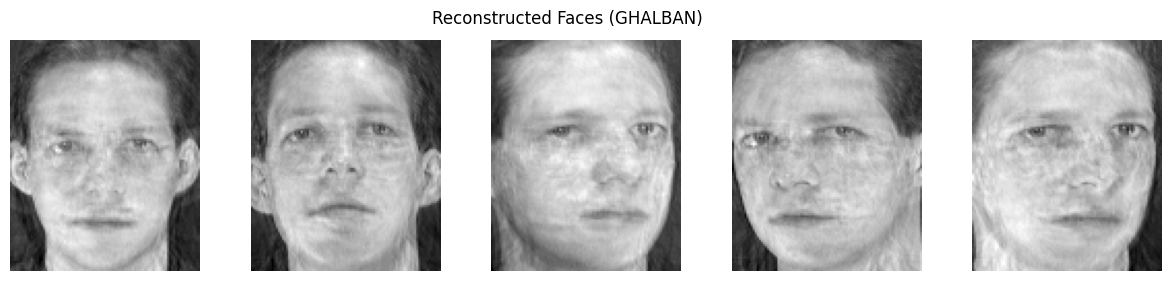

In [4]:
# Visualize a few reconstructed faces
reconstructed = pca.inverse_transform(X_train_pca[:5])

# Visualize a few reconstructed faces
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
    axs[i].axis('off')
plt.suptitle('Reconstructed Faces (GHALBAN)')
plt.show()

Reconstructed shape: (5, 10304)


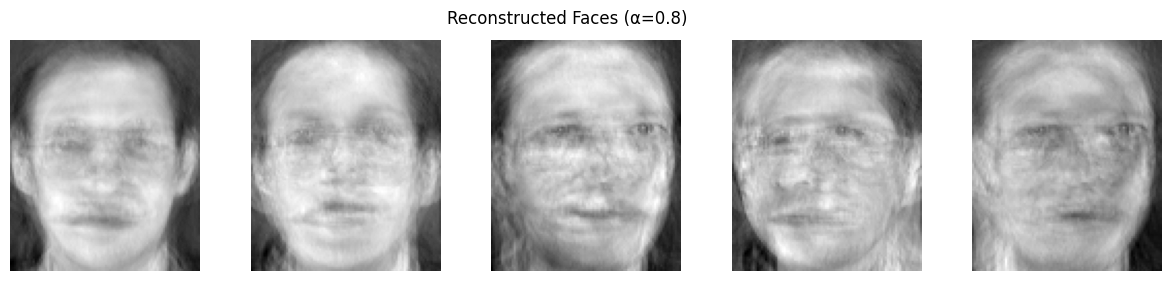

Reconstructed shape: (5, 10304)


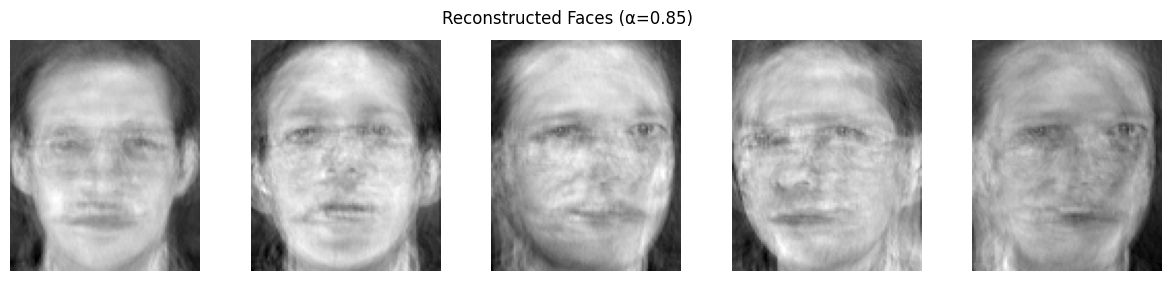

Reconstructed shape: (5, 10304)


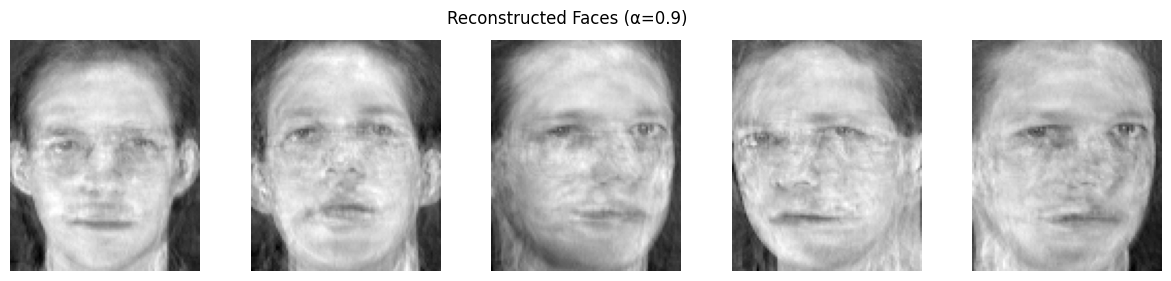

Reconstructed shape: (5, 10304)


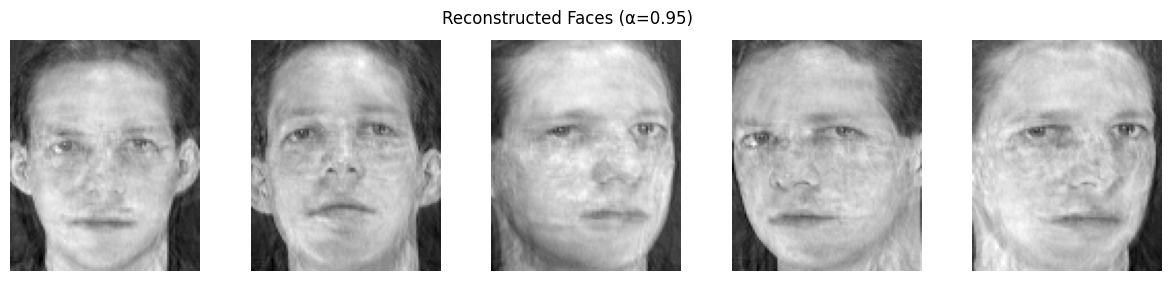

In [5]:
# PCA with variance retention
alphas = [0.8, 0.85, 0.9, 0.95]
pca_results = {}
X_train_pca = {}
X_test_pca = {}

for alpha in alphas:
    pca = PCA_GHALBAN(alpha=alpha)
    # we fit first using the training set
    pca.fit(X_train)

    # then we transform the training and test sets
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # print(f'Alpha: {alpha}, Components retained: {pca.components}')
    pca_results[alpha] = {
        'pca': pca,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
    }

    # Visualize a few reconstructed faces
    reconstructed = pca.inverse_transform(X_train_pca[:5])
    print(f'Reconstructed shape: {reconstructed.shape}')
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Reconstructed Faces (α={alpha})')
    plt.show()

In [6]:
# Save arrays for reuse in clustering step
np.save('./npy/X_train.npy', X_train)
np.save('./npy/X_test.npy', X_test)
np.save('./npy/y_train.npy', y_train)
np.save('./npy/y_test.npy', y_test)
for alpha in alphas:
    np.save(f'./npy/pca_alpha_{alpha}_train.npy', pca_results[alpha]['X_train_pca'])
    np.save(f'./npy/pca_alpha_{alpha}_test.npy', pca_results[alpha]['X_test_pca'])  

## KMeans Algorithm

In [7]:
import importlib
import kmeans as Models
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score

importlib.reload(Models)

<module 'kmeans' from '/home/rowan/Desktop/Rowans_CSE/Term8/Face_Recognition_Problem/kmeans.py'>

In [8]:
def mapping_clusters_to_labels(cluster_indices, true_labels):
    cluster_label_map = {}
    
    for cluster in np.unique(cluster_indices):
        labels = true_labels[cluster_indices == cluster]

        if len(labels) > 0:
            majority_label = Counter(labels).most_common(1)[0][0]
            cluster_label_map[cluster] = majority_label
        else:
            cluster_label_map[cluster] = -1  # fallback
    return cluster_label_map

In [9]:
k_values = [20, 40, 60]
results = {}  # To store accuracy for each (alpha, K)

best_acc = 0
best_model = None
best_alpha = 0.8
cluster_label_mapping = []
for alpha in alphas:
    results[alpha] = {}
    for k in k_values:
        kmeans_model = Models.KMeans(n_clusters = k, random_state = 42)
        pca = pca_results[alpha]['pca']
        X_train_pca = pca_results[alpha]['X_train_pca']
        X_test_pca = pca_results[alpha]['X_test_pca']

        # Fit KMeans
        kmeans_model.fit(X_train_pca)

        # Predict clusters
        cluster_indices = kmeans_model.predict(X_train_pca)
        cluster_label_map = mapping_clusters_to_labels(cluster_indices, y_train)
        
        y_pred_train = np.array([cluster_label_map[c] for c in cluster_indices])
        
        y_pred_test_cluster_indices = kmeans_model.predict(X_test_pca)
        
        training_acc = accuracy_score(y_pred_train, y_train)
    
        test_cluster_indices = kmeans_model.predict(X_test_pca)
        
        y_pred_test = np.array([cluster_label_map[c] for c in test_cluster_indices])
        
        training_acc = accuracy_score(y_pred_train, y_train)
        testing_acc = accuracy_score(y_pred_test, y_test)
        
        if training_acc > best_acc:
            best_acc = training_acc
            best_model = kmeans_model
            best_alpha = alpha
            cluster_label_mapping = cluster_label_map

        results[alpha][k] = {
            "training_acc": training_acc,
            "testing_acc": testing_acc
        }
        print(f'Alpha: {alpha}, K: {k}, Training Accuracy: {training_acc:.4f}, Testing Accuracy: {testing_acc}')

Alpha: 0.8, K: 20, Training Accuracy: 0.4150, Testing Accuracy: 0.36
Alpha: 0.8, K: 40, Training Accuracy: 0.6700, Testing Accuracy: 0.65
Alpha: 0.8, K: 60, Training Accuracy: 0.8150, Testing Accuracy: 0.77
Alpha: 0.85, K: 20, Training Accuracy: 0.4150, Testing Accuracy: 0.385
Alpha: 0.85, K: 40, Training Accuracy: 0.6550, Testing Accuracy: 0.62
Alpha: 0.85, K: 60, Training Accuracy: 0.8000, Testing Accuracy: 0.74
Alpha: 0.9, K: 20, Training Accuracy: 0.4050, Testing Accuracy: 0.385
Alpha: 0.9, K: 40, Training Accuracy: 0.6550, Testing Accuracy: 0.62
Alpha: 0.9, K: 60, Training Accuracy: 0.7850, Testing Accuracy: 0.73
Alpha: 0.95, K: 20, Training Accuracy: 0.4000, Testing Accuracy: 0.375
Alpha: 0.95, K: 40, Training Accuracy: 0.6350, Testing Accuracy: 0.635
Alpha: 0.95, K: 60, Training Accuracy: 0.7750, Testing Accuracy: 0.715


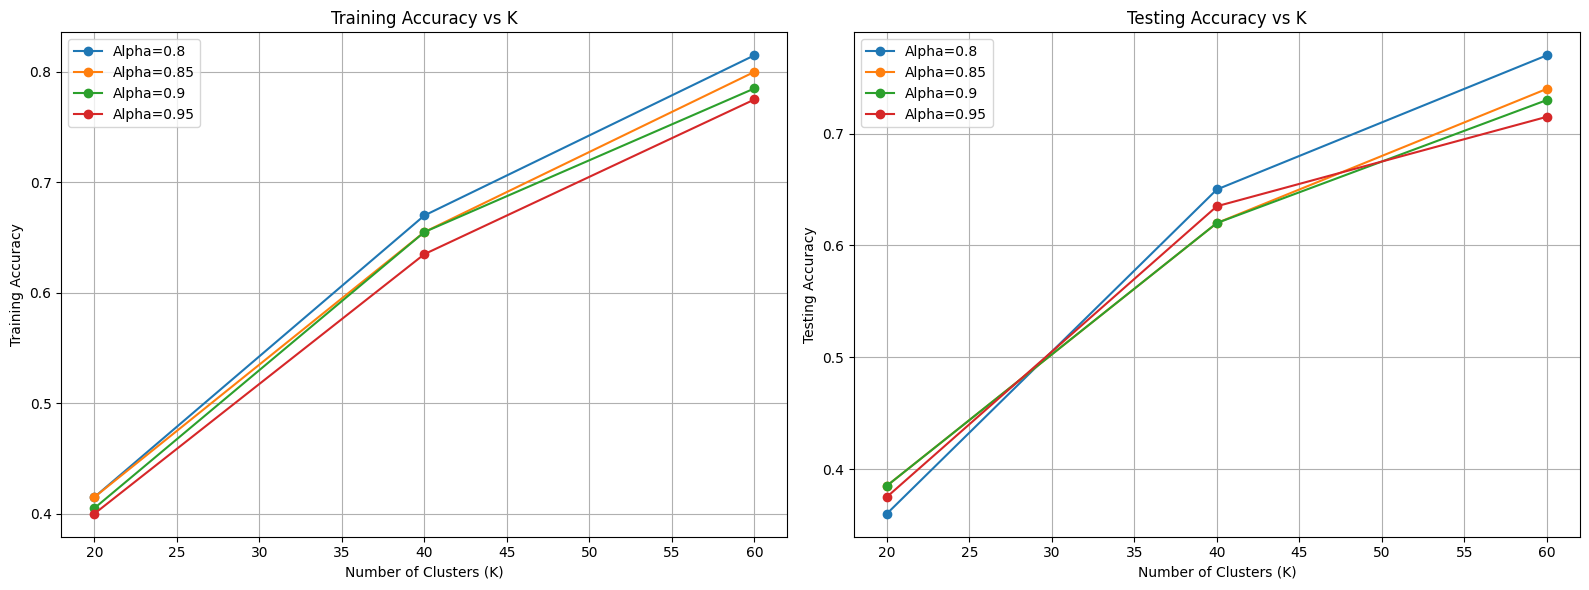

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Training Accuracy
for alpha in results:
    training_accuracies = [results[alpha][k]['training_acc'] for k in k_values]
    axes[0].plot(k_values, training_accuracies, marker='o', label=f'Alpha={alpha}')

axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Training Accuracy vs K')
axes[0].legend()
axes[0].grid(True)

# Plot Testing Accuracy
for alpha in results:
    testing_accuracies = [results[alpha][k]['testing_acc'] for k in k_values]
    axes[1].plot(k_values, testing_accuracies, marker='o', label=f'Alpha={alpha}')

axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Testing Accuracy')
axes[1].set_title('Testing Accuracy vs K')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

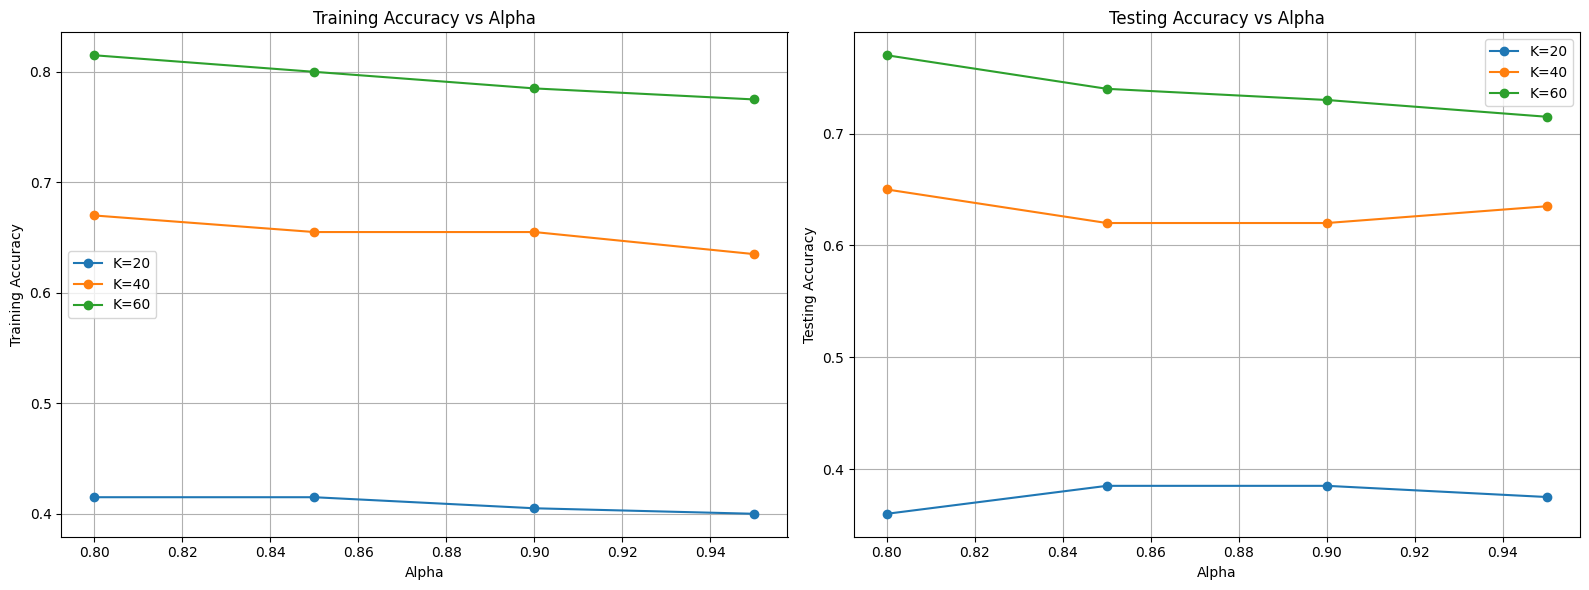

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Training Accuracy vs Alpha
for k in k_values:
    training_accuracies = [results[alpha][k]['training_acc'] for alpha in alphas]
    axes[0].plot(alphas, training_accuracies, marker='o', label=f'K={k}')

axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Training Accuracy vs Alpha')
axes[0].legend()
axes[0].grid(True)

# Plot Testing Accuracy vs Alpha
for k in k_values:
    testing_accuracies = [results[alpha][k]['testing_acc'] for alpha in alphas]
    axes[1].plot(alphas, testing_accuracies, marker='o', label=f'K={k}')

axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Testing Accuracy')
axes[1].set_title('Testing Accuracy vs Alpha')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Best K-Means Model Evaluating**

In [12]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

Test Accuracy: 0.7400
Test F1-Score: 0.7204


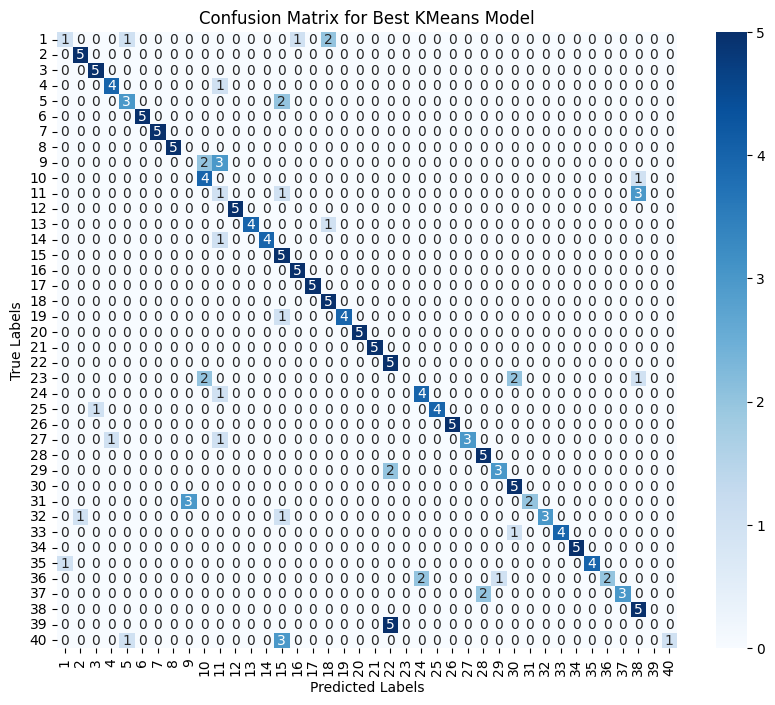

In [13]:
pca = pca_results[best_alpha]['pca']
X_test_pca = pca_results[best_alpha]['X_test_pca']

# Predict clusters for the test set
y_pred_test_cluster_indices = best_model.predict(X_test_pca)
y_pred_test = np.array([cluster_label_mapping[c] for c in cluster_indices])
# Calculate Accuracy
test_accuracy = accuracy_score(y_pred_test, y_test)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_test, average='macro')  # or 'weighted'

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print Results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Best KMeans Model')
plt.show()

## GMM Algorithm

In [14]:
def map_cluster_to_id(train_clusters, y_train, K):
    cluster_to_id = {}
    for cluster in range(K):
        members = y_train[train_clusters == cluster] 
    
        if len(members) == 0:
            cluster_to_id[cluster] = -1
            print(f"Warning: cluster {cluster} has no members.")
        else:
            cluster_to_id[cluster] = np.bincount(members).argmax()
    return cluster_to_id

α=0.8, K=20 → training accuracy=0.460 testing accuracy=0.440, f1=0.323
α=0.8, K=40 → training accuracy=0.770 testing accuracy=0.745, f1=0.692
α=0.8, K=60 → training accuracy=0.925 testing accuracy=0.865, f1=0.860
α=0.85, K=20 → training accuracy=0.470 testing accuracy=0.430, f1=0.318
α=0.85, K=40 → training accuracy=0.800 testing accuracy=0.770, f1=0.733
α=0.85, K=60 → training accuracy=0.925 testing accuracy=0.875, f1=0.870
α=0.9, K=20 → training accuracy=0.450 testing accuracy=0.420, f1=0.297
α=0.9, K=40 → training accuracy=0.730 testing accuracy=0.660, f1=0.597
α=0.9, K=60 → training accuracy=0.905 testing accuracy=0.795, f1=0.786
α=0.95, K=20 → training accuracy=0.445 testing accuracy=0.410, f1=0.290
α=0.95, K=40 → training accuracy=0.750 testing accuracy=0.700, f1=0.653
α=0.95, K=60 → training accuracy=0.910 testing accuracy=0.855, f1=0.847


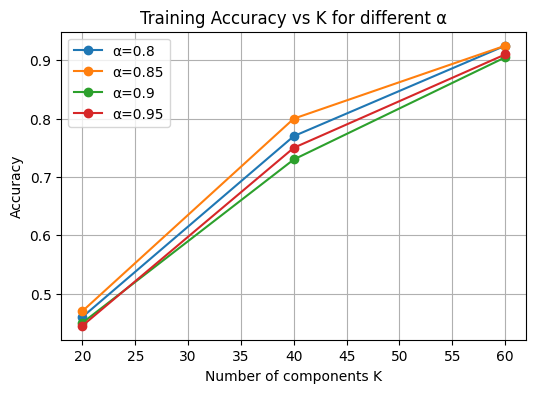

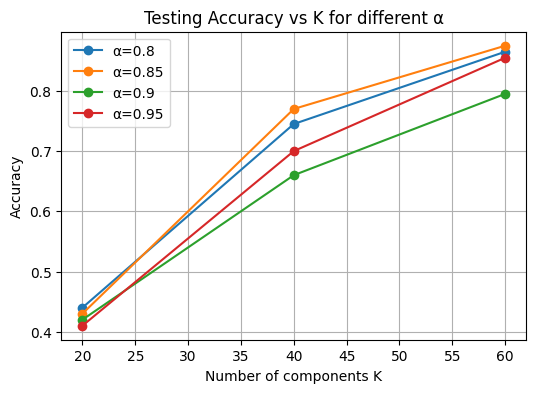

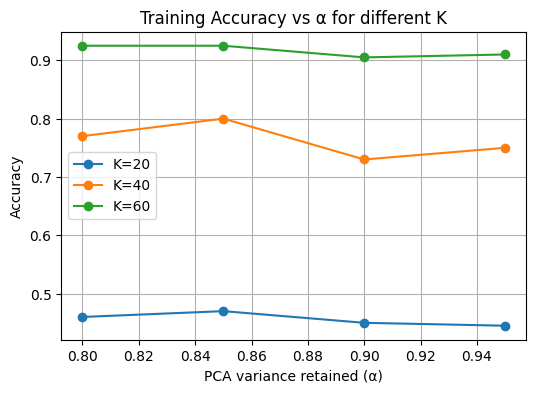

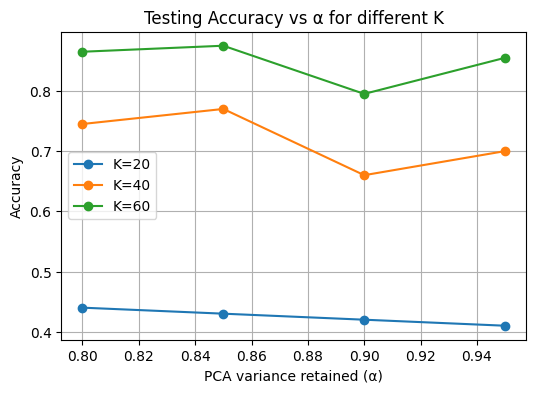


Accuracy (rows=alpha, cols=K):
K         20    40     60
alpha                    
0.80   0.460  0.77  0.925
0.85   0.470  0.80  0.925
0.90   0.450  0.73  0.905
0.95   0.445  0.75  0.910

Testing Accuracy (rows=alpha, cols=K):
K        20     40     60
alpha                    
0.80   0.44  0.745  0.865
0.85   0.43  0.770  0.875
0.90   0.42  0.660  0.795
0.95   0.41  0.700  0.855


In [15]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from GMM import GMM 

alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20, 40, 60]

results = []
best_gmm = None
best_K = 0
best_alpha = 0
best_acc = 0
# Loop over each α and each K 
for alpha in alphas:
    X_train = pca_results[alpha]['X_train_pca']
    X_test = pca_results[alpha]['X_test_pca']
    
    for K in Ks:
        gmm = GMM(n_components=K, max_iter=100, tol=1e-4, random_state=42)
        gmm.fit(X_train)

        # hard‐assign each training point to a cluster
        train_clusters = gmm.perform_hard_prediction(X_train)

        # assign each cluster to the most frequent true label in that cluster 
        cluster_to_id = map_cluster_to_id(train_clusters, y_train, K)


        # training accuracy
        train_pred = np.array([cluster_to_id[c] for c in train_clusters])
        train_acc = accuracy_score(y_train, train_pred)

        # hard‐assign each test point to a cluster
        test_clusters = gmm.perform_hard_prediction(X_test)
        
        y_pred = np.array([cluster_to_id[c] for c in test_clusters])

        # testing accuracy and f1 score
        test_acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred, average='macro')
        
        if train_acc > best_acc:
            best_acc = train_acc
            best_gmm = gmm
            best_K = K
            best_alpha = alpha

        # store results
        results.append({
            'alpha': alpha,
            'K': K,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc, 
            'f1_macro': f1
        })
        print(f"α={alpha}, K={K} → training accuracy={train_acc:.3f} testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# to dataframe 
df = pd.DataFrame(results)
pivot_training_acc = df.pivot(index='alpha', columns='K', values='train_accuracy')
pivot_test_acc = df.pivot(index='alpha', columns='K', values='test_accuracy')


# Training Accuracy vs K (one curve per α)
plt.figure(figsize=(6,4))
for alpha in alphas:
    plt.plot(Ks, pivot_training_acc.loc[alpha], marker='o', label=f'α={alpha}')
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs K for different α')
plt.legend()
plt.grid(True)


# Testing Accuracy vs K (one curve per α)
plt.figure(figsize=(6,4))
for alpha in alphas:
    plt.plot(Ks, pivot_test_acc.loc[alpha], marker='o', label=f'α={alpha}')
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs K for different α')
plt.legend()
plt.grid(True)



# Training Accuracy vs α (one curve per K)
plt.figure(figsize=(6,4))
for K in Ks:
    plt.plot(alphas, pivot_training_acc[K], marker='o', label=f'K={K}')
plt.xlabel('PCA variance retained (α)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs α for different K')
plt.legend()
plt.grid(True)


# Testing Accuracy vs α (one curve per K)
plt.figure(figsize=(6,4))
for K in Ks:
    plt.plot(alphas, pivot_test_acc[K], marker='o', label=f'K={K}')
plt.xlabel('PCA variance retained (α)')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs α for different K')
plt.legend()
plt.grid(True)


plt.show()

# results as table 
print("\nAccuracy (rows=alpha, cols=K):")
print(pivot_training_acc)
print("\nTesting Accuracy (rows=alpha, cols=K):")
print(pivot_test_acc)

Best model: α=0.8, K=60 → testing accuracy=0.865, f1=0.860


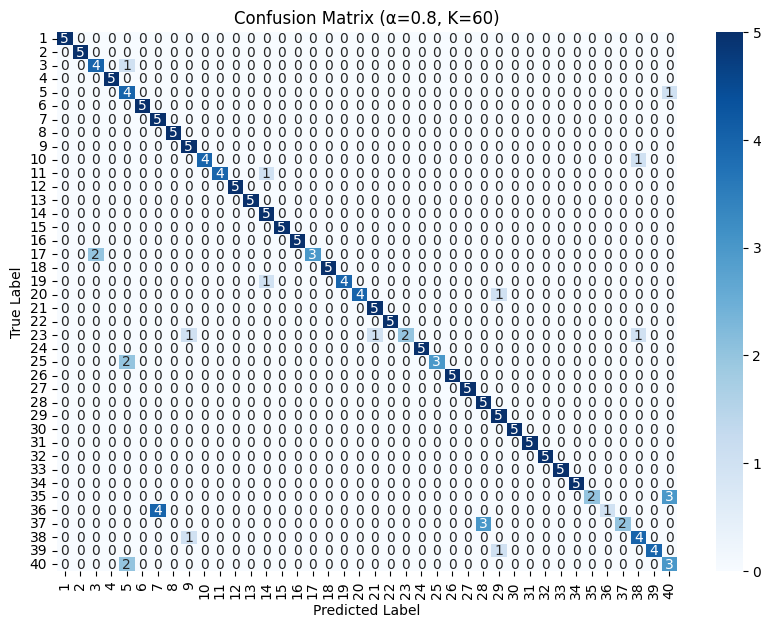

In [19]:
# Evaluate the best model on the test set
gmm_best_model = GMM(n_components=best_K, max_iter=100, tol=1e-4, random_state=42)
gmm_best_model.fit(pca_results[best_alpha]['X_train_pca'])
train_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_train_pca'])

# assign each cluster to the most frequent true label in that cluster
cluster_to_id = map_cluster_to_id(train_clusters, y_train, best_K)

# test clusters
test_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_test_pca'])
y_pred = np.array([cluster_to_id[c] for c in test_clusters])

test_acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='macro')
print(f"Best model: α={best_alpha}, K={best_K} → testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.title(f"Confusion Matrix (α={best_alpha}, K={best_K})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## BONUS: Autoencoder
### Training

In [31]:
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

In [25]:
from autoencoder import AutoEncoder
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
# Parameters
input_dim = X_train.shape[1]  # 10304
hidden_dim = 64
bottleneck_dim = 32              
batch_size = 16
learning_rate = 1e-4
num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # ensure float32
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False)

model = AutoEncoder(input_dim, hidden_dim, bottleneck_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training 
for epoch in range(num_epochs):
    model.train() # setting the model to training mode
    run_loss = 0.0
    for batch in train_loader:
        # Zero the gradients
        data = batch[0] # Ensure data is float
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Compute loss
        loss = criterion(outputs, data)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    
    epoch_loss = run_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
# Save the model
torch.save(model.state_dict(), 'autoencoder.pth')
# Load the model
model.load_state_dict(torch.load('autoencoder.pth'))
model.eval()
# Test the model    


Epoch [1/30], Loss: 15046.1774
Epoch [2/30], Loss: 15109.8291
Epoch [3/30], Loss: 15054.2234
Epoch [4/30], Loss: 15067.2571
Epoch [5/30], Loss: 15071.4573
Epoch [6/30], Loss: 14988.0805
Epoch [7/30], Loss: 15007.4854
Epoch [8/30], Loss: 14995.4905
Epoch [9/30], Loss: 15083.2700
Epoch [10/30], Loss: 15038.9997
Epoch [11/30], Loss: 15005.5524
Epoch [12/30], Loss: 15054.4013
Epoch [13/30], Loss: 15062.9568
Epoch [14/30], Loss: 15037.9103
Epoch [15/30], Loss: 15048.9123
Epoch [16/30], Loss: 15029.3148
Epoch [17/30], Loss: 15112.8436
Epoch [18/30], Loss: 14976.4319
Epoch [19/30], Loss: 15049.0959
Epoch [20/30], Loss: 15053.0592
Epoch [21/30], Loss: 15028.4609
Epoch [22/30], Loss: 15142.6284
Epoch [23/30], Loss: 15040.9087
Epoch [24/30], Loss: 15056.1984
Epoch [25/30], Loss: 15053.9313
Epoch [26/30], Loss: 15050.0076
Epoch [27/30], Loss: 15151.9075
Epoch [28/30], Loss: 15034.0939
Epoch [29/30], Loss: 15051.8232
Epoch [30/30], Loss: 15093.6094


/tmp/ipykernel_40461/277358877.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder.pth'))


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=10304, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10304, bias=True)
    (3): Sigmoid()
  )
)

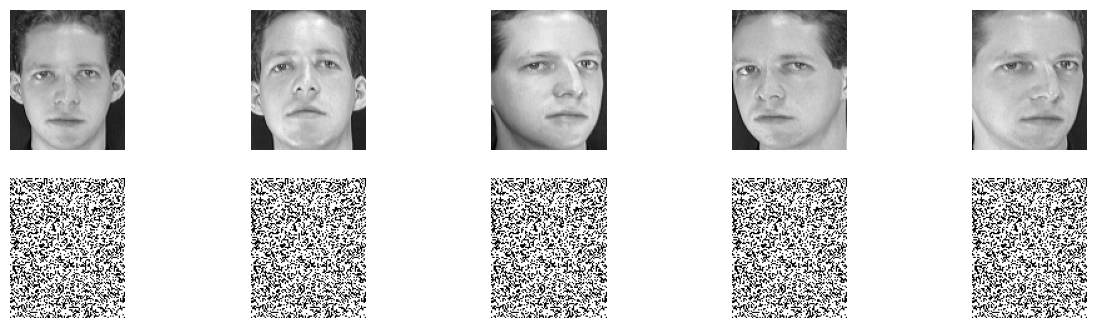

In [26]:
import matplotlib.pyplot as plt

model.eval()  # Set model to evaluation mode
sample = torch.tensor(X_train[:5], dtype=torch.float32)  # Take 5 examples
reconstructed = model(sample).detach().numpy()

fig, axs = plt.subplots(2, 5, figsize=(15, 4))
for i in range(5):
    axs[0, i].imshow(sample[i].reshape(112, 92), cmap='gray')        # original
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed[i].reshape(112, 92), cmap='gray') # reconstructed
    axs[1, i].axis('off')
plt.show()


In [27]:
from autoencoder import AutoEncoder


def train_autoencoder(X_train, X_validate, input_dim, hidden_dim, bottleneck_dim, batch_size, lr, num_epochs):
    model = AutoEncoder(input_dim, hidden_dim, bottleneck_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        perm = torch.randperm(X_train.size(0))
        model.train()  
        run_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            indices = perm[i:i + batch_size]
            batch = X_train[indices]
            data = batch[0]
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        epoch_loss = run_loss / len(train_loader)
        if(epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
    model.eval()  
    with torch.no_grad():
        reconstructed = model(X_validate)
        loss = criterion(reconstructed, X_validate)
        avg_loss = loss.item()
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss
    

In [28]:
import itertools
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

validation_size = 0.2*len(X_train_tensor)
X_validate_tensor = X_train_tensor[len(X_train_tensor)-int(validation_size):]
X_train_tensor = X_train_tensor[:int(validation_size)]

best_model = None  
best_loss = float('inf')
best_config = None


# Grid search
input_dim = X_train_tensor.shape[1]
hidden_dims = [256, 512, 1024]
bottleneck_dims = [64, 128]
learning_rates = [0.001]
batch_sizes = [64, 128, 256]
epochs = 100

for hidden_dim, bottleneck_dim, lr, batch_size in itertools.product(hidden_dims, bottleneck_dims, learning_rates, batch_sizes):
    print(f"Training with hidden_dim={hidden_dim}, bottleneck_dim={bottleneck_dim}, lr={lr}, batch_size={batch_size}")
    avg_loss = train_autoencoder(
        X_train_tensor,
        X_validate_tensor,
        input_dim,
        hidden_dim,
        bottleneck_dim,
        batch_size,
        lr,
        epochs
    )
    print(f"Average loss: {avg_loss:.6f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_config = {
            'hidden_dim': hidden_dim,
            'bottleneck_dim': bottleneck_dim,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), 'best_autoencoder.pth')
        print("Best model saved.")  
print("\nBest Configuration Found:")
print(best_config)
print(f"Best Loss: {best_loss:.6f}")
# Load the best model
best_model = AutoEncoder(input_dim, best_config['hidden_dim'], best_config['bottleneck_dim']) 




Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_size=64
Epoch [10/100], Loss: 1394.9223
Epoch [20/100], Loss: 1323.3903
Epoch [30/100], Loss: 1726.7177
Epoch [40/100], Loss: 1409.5092
Epoch [50/100], Loss: 1189.9766
Epoch [60/100], Loss: 1547.4184
Epoch [70/100], Loss: 1689.8173
Epoch [80/100], Loss: 1119.7061
Epoch [90/100], Loss: 1674.0239
Epoch [100/100], Loss: 1514.8679
Validation Loss: 13431.3838
Average loss: 13431.383789
Best model saved.
Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_size=128
Epoch [10/100], Loss: 1676.4923
Epoch [20/100], Loss: 1251.3253
Epoch [30/100], Loss: 1229.0284
Epoch [40/100], Loss: 1228.7784
Epoch [50/100], Loss: 1131.5391
Epoch [60/100], Loss: 1657.3854
Epoch [70/100], Loss: 1148.3576
Epoch [80/100], Loss: 1228.4576
Epoch [90/100], Loss: 1657.1878
Epoch [100/100], Loss: 1392.0708
Validation Loss: 13429.7754
Average loss: 13429.775391
Best model saved.
Training with hidden_dim=256, bottleneck_dim=64, lr=0.001, batch_

### Visualization

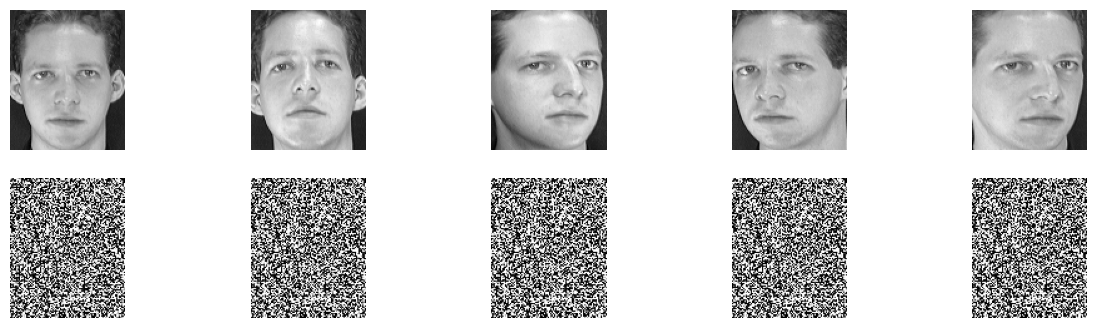

In [29]:
with torch.no_grad():
    sample = X_train_tensor[:5]
    reconstructed = best_model(sample).detach().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(15, 4))
    for i in range(5):
        axs[0, i].imshow(sample[i].reshape(112, 92), cmap='gray')        # original
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed[i].reshape(112, 92), cmap='gray') # reconstructed
        axs[1, i].axis('off')

    plt.show()


In [30]:
# Data prep for kmeans and GMM using best model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

X_train_autoencoder = best_model.encode(X_train_tensor).detach().numpy()
X_test_autoencoder = best_model.encode(X_test_tensor).detach().numpy()
np.save('./npy/X_train_autoencoder.npy', X_train_autoencoder)
np.save('./npy/X_test_autoencoder.npy', X_test_autoencoder)